In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('../plotting/style_sheet.mplstyle')
from toy_rnn.dataset import Dataset
from plotting import plotting_utils
import sklearn
from toy_rnn.dataset import Dataset
from toy_rnn.rnn import MultiSetRNN
from synthetic_data.gaussian_process import GPSpikeGenerator

In [3]:
# Configuration
LATENT_DIM = 3
LATENT_TIMESCALE = 0.1
DT = 0.01
MEDIAN_FIRING_RATE = 20.0
NUM_NEURONS = 50

In [4]:
# Dataset, responsible for generating "synthetic" data 
data_generator = GPSpikeGenerator(
    latent_dim=LATENT_DIM,
    kernel_type="rbf",
    kernel_params={'tau' : LATENT_TIMESCALE},
    dt=DT,
    median_firing_rate=MEDIAN_FIRING_RATE,
    num_neurons=NUM_NEURONS,
)

In [18]:
trial = data_generator.sample(total_time=5.0)

(time, latents, firing_rates, spike_counts, spike_times, spike_unit_ids) = trial

Checking distribution of normalized logrates: mean=-0.04, std=0.95
Checking distribution of lognormalize rates: median=19.95, std=6.05


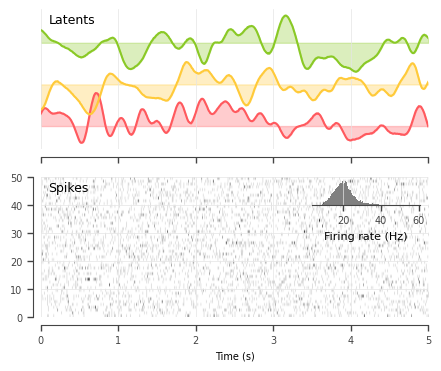

In [19]:
from matplotlib.gridspec import GridSpec

data_fig = plt.figure(figsize=(5, 4)) # Increased figure width for histograms
gs = GridSpec(
    nrows=2, 
    ncols=1,
    figure=data_fig,
    height_ratios=[1, 1],

)

ax_latents = data_fig.add_subplot(gs[0, 0])
ax_spikes = data_fig.add_subplot(gs[1, 0], sharex=ax_latents)

# Plot latents
for l in range(latents.shape[1]):
    line = ax_latents.plot(time, 3*l + latents[:, l])
    ax_latents.fill_between(time, 3*l + latents[:, l], 3*l, alpha=0.3, color=line[0].get_color())
ax_latents.text(0.02, 0.9, "Latents", transform=ax_latents.transAxes)
ax_latents.set_prop_cycle(None)  # reset color cycle
ax_latents.tick_params(axis='x', labelbottom=False) # Remove X labels from top plot
ax_latents.yaxis.set_visible(False) # Remove Y axis from latent plot
ax_latents.spines['left'].set_visible(False)

# Plot spike counts
im = ax_spikes.imshow((spike_counts/DT).T, aspect='auto', cmap='Greys', origin='lower', extent=[time[0], time[-1], 0, spike_counts.shape[1]])
ax_spikes.text(0.02, 0.9, "Spikes", transform=ax_spikes.transAxes)
ax_spikes.set_xlabel("Time (s)")

# Plot spike count histogram
ax_spike_hist = ax_spikes.inset_axes([0.7, 0.8, 0.28, 0.18])
ax_spike_hist.hist(firing_rates.flatten(), bins=200, color='gray')
ax_spike_hist.tick_params(axis='y', labelleft=False) # Remove Y labels
ax_spike_hist.spines['left'].set_visible(False)
ax_spike_hist.yaxis.set_visible(False)
ax_spike_hist.set_xlabel("Firing rate (Hz)", fontdict={'size': 8})

# Apply the utility function
plotting_utils.outset_axes(ax_latents)
plotting_utils.outset_axes(ax_spikes)

In [15]:
def fit_pcs(data, n_pcs=None, ground_truth=None,):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_pcs)
    data_centered = data - np.mean(data, axis=0, keepdims=True)
    pcs = pca.fit_transform(data_centered)
    if ground_truth is not None:
        from sklearn.linear_model import LinearRegression
        print("Aligning PCs to ground truth using linear regression...")
        reg = LinearRegression(fit_intercept=False).fit(pcs, ground_truth)
        pcs_aligned = reg.predict(pcs)
        return pcs_aligned
    return pcs

In [16]:
latents.shape

(501, 3)

Aligning PCs to ground truth using linear regression...
Variance explained by first 3 PCs: 0.065


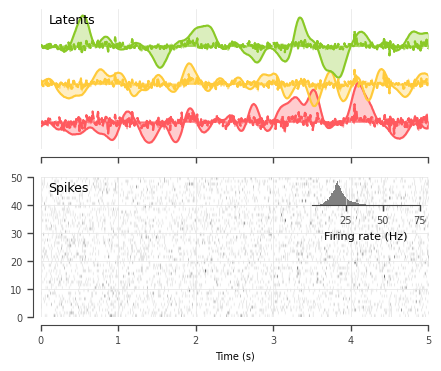

In [14]:
N_PCS = 3 
pcs = fit_pcs(spike_counts, n_pcs=N_PCS, ground_truth=latents)
r_sq = sklearn.metrics.r2_score(latents[:, :N_PCS], pcs)
print(f'Variance explained by first {N_PCS} PCs: {r_sq:.3f}')

# plot the PCs over the latents 
# reset the color cycle
ax_latents.set_prop_cycle(None)
for l in range(pcs.shape[1]):
    line = ax_latents.plot(time, 3*l + pcs[:, l], linestyle='--')
    ax_latents.fill_between(time, 3*l + pcs[:, l], 3*l, alpha=0.3, color=line[0].get_color())

data_fig

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Using device: {device}")

# 1. Init Data
dataset = Dataset(
    num_sets=NUM_SETS, 
    num_neurons=NUM_NEURONS, 
    latent_dim=LATENT_DIM, 
    latent_timescale=LATENT_TIMESCALE, 
    dt=DT, 
    trial_duration=TRIAL_DURATION)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

# 2. Init Model
model = MultiSetRNN(
    num_sets=NUM_SETS,
    input_size=NUM_NEURONS,    # Input is spike counts
    hidden_size=HIDDEN_SIZE,   # Size of LSTM hidden state
    latent_dim=LATENT_DIM      # Output target dimension
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 3. Training Loop
# Note: Since it's an IterableDataset with 'while True', you need a break condition
max_steps = 1000

for step, batch in enumerate(dataloader):
    if step >= max_steps:
        break
    
    # Move data to device
    batch = {k: v.to(device) for k, v in batch.items()}

    # Unpack data
    x = batch["spike_counts"]  # (Batch, Time, Neurons)
    y = batch["latents"]       # (Batch, Time, Latents)
    indices = batch["dataset_idx"] # (Batch)
    
    # Forward pass
    # We pass both the data AND the indices so the model knows how to route
    predictions = model(x, indices)
    
    # Loss calculation
    loss = criterion(predictions, y)
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

(array([5.980e+02, 1.224e+03, 1.198e+03, 1.062e+03, 9.670e+02, 7.250e+02,
        5.580e+02, 4.910e+02, 4.050e+02, 3.590e+02, 2.830e+02, 2.410e+02,
        2.130e+02, 1.820e+02, 1.680e+02, 1.160e+02, 1.040e+02, 1.200e+02,
        8.700e+01, 9.200e+01, 8.600e+01, 6.600e+01, 5.600e+01, 4.600e+01,
        5.400e+01, 5.000e+01, 3.600e+01, 3.200e+01, 3.200e+01, 2.600e+01,
        1.900e+01, 2.000e+01, 1.900e+01, 1.800e+01, 2.000e+01, 2.100e+01,
        2.100e+01, 1.300e+01, 1.000e+01, 1.000e+01, 1.400e+01, 9.000e+00,
        6.000e+00, 9.000e+00, 6.000e+00, 5.000e+00, 4.000e+00, 6.000e+00,
        5.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 6.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 5.000e+00, 1.000e+00, 7.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+0

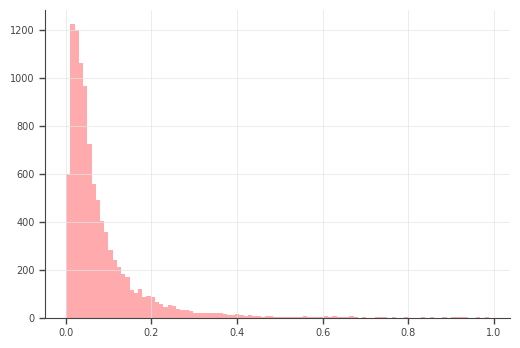

In [20]:
import numpy as np 
a = np.random.randn(10000)
ea = np.exp(a)


# plt.hist(ea, alpha=0.5, bins=1000)
plt.hist(np.tanh(ea / np.exp(3)), alpha=0.5, bins=100)